# Продвинутое глубокое обучение и обучение с подкреплением: ДЗ 1

Студент: Бакулев Владимир Леонидович

Группа: MADE-DS-32

Почта: vlbakulev@gmail.com

In [1]:
import gym

from blackjack_double import BlackjackDoubleEnv
from blackjack_countcard import BlackjackCountCardEnv

import numpy as np
import pandas as pd

from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

### Часть первая, с блекджеком и стратегиями

- Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
    
- Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

- Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [2]:
PLAYER_CARD = list(range(4, 32))
print(f"Возможные суммы очков на руках у игрока:\n{PLAYER_CARD}\n")

DEALER_CARD= list(range(1, 11))
print(f"Возможные суммы очков на руках у диллера:\n{DEALER_CARD}\n")

USABLE_ACE_LIST = [True, False]

COUNT_STATE = len(PLAYER_CARD) * len(DEALER_CARD) * len(USABLE_ACE_LIST)
print(f"Количество возможных состояний: {COUNT_STATE}\n")

Возможные суммы очков на руках у игрока:
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

Возможные суммы очков на руках у диллера:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Количество возможных состояний: 560



In [3]:
def make_dict_states(counting_system=None):
    states_list = []
    for player_ in PLAYER_CARD:
        for dealer_ in DEALER_CARD:
            for usable_ace_ in USABLE_ACE_LIST:
                if counting_system is not None:
                    for count_ in counting_system:
                        states_list.append((player_, dealer_, usable_ace_, count_))
                else:
                    states_list.append((player_, dealer_, usable_ace_))
    
    idx_to_state, state_to_idx = {}, {}
    for idx, state in enumerate(states_list):
        idx_to_state[idx] = state
        state_to_idx[state] = idx
    
    state_list = list(state_to_idx.keys())
    return idx_to_state, state_to_idx, state_list

idx_to_state, state_to_idx, STATE_LIST = make_dict_states()

In [4]:
nS, nA = len(STATE_LIST), 2
print(f"Для первой части: количесвто состояний: {nS}, количество дейсвтий: {nA}")

Для первой части: количесвто состояний: 560, количество дейсвтий: 2


In [5]:
def get_random_V():
    V = np.random.random(nS)
    return V

V = get_random_V()

In [6]:
def get_random_Q():
    Q = np.random.random(size=(nS, nA))
    return Q

Q = get_random_Q()

In [7]:
def generate_pi_stadn_19_20_21(state_list=STATE_LIST):
    pi_value = []
    for state in state_list:
        player_, dealer_, usable_ace_ = state
        if player_ in [19, 20, 21]:
            pi_value.append(0)
        else:
            pi_value.append(1)
    pi = {k: v for k, v in zip(state_list, pi_value)}
    return list(pi.values())

pi_stand_19_20_21 = generate_pi_stadn_19_20_21()

In [8]:
def get_color(action):
    if action == "stand":
        return "color: red"
    elif action == "hit":
        return "color: green"
    elif action == "double":
        return "color: orange"
    
def plot_strategy(pi):
    pi_dict = {}
    map_action = {0: "stand", 1: "hit", 2: "double"}
    for player_ in PLAYER_CARD:
        if player_ > 21:
            break
        for dealer_ in DEALER_CARD:
            for usable_ace_ in USABLE_ACE_LIST:
                action = map_action[pi[state_to_idx[(player_, dealer_, usable_ace_)]]]
                col_name = "".join(["d: ", str(dealer_), ", u_a: ", str(usable_ace_)])
                if pi_dict.get(col_name) is None:
                    pi_dict[col_name] = [action]
                else:
                    pi_dict[col_name].append(action)
                    
    player_stage = ["".join(["p: ", str(p)]) for p in PLAYER_CARD[:18]]
    pi_df = pd.DataFrame(pi_dict, index=player_stage).transpose()
    return pi_df.style.applymap(get_color)
    
plot_strategy(pi_stand_19_20_21)   

,p: 4,p: 5,p: 6,p: 7,p: 8,p: 9,p: 10,p: 11,p: 12,p: 13,p: 14,p: 15,p: 16,p: 17,p: 18,p: 19,p: 20,p: 21
"d: 1, u_a: True",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 1, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 2, u_a: True",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 2, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 3, u_a: True",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 3, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 4, u_a: True",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 4, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 5, u_a: True",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 5, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand


In [9]:
def run_episode(env, pi, is_counting_game=False):
    states, rewards = [], [0.]
    
    if is_counting_game:
        player, dealer, usable_ace, count_card = env.reset()
        idx_state = state_to_idx[(player, dealer, usable_ace, count_card)]
    else:
        player, dealer, usable_ace = env.reset()
        idx_state = state_to_idx[(player, dealer, usable_ace)]
        
    states.append(idx_state)
    
    for _ in range(1_000):
        observation, reward, done, info = env.step(pi[idx_state])
        
        if is_counting_game:
            player, dealer, usable_ace, count_card = observation
            idx_state = state_to_idx[(player, dealer, usable_ace, count_card)]
        else:
            player, dealer, usable_ace = env.reset()
            idx_state = state_to_idx[(player, dealer, usable_ace)]
        
        states.append(idx_state)
        rewards.append(reward)
        
        if done:
            break
        
    return states, rewards

In [10]:
def run_episode_actions(env, pi, eps=0.0, is_counting_game=False):
    
    if is_counting_game:
        player, dealer, usable_ace, count_card = env.reset()
        idx_state = state_to_idx[(player, dealer, usable_ace, count_card)]
    else:
        player, dealer, usable_ace = env.reset()
        idx_state = state_to_idx[(player, dealer, usable_ace)]
    
    next_action = pi[idx_state] if np.random.rand() > eps else np.random.randint(nA)
    states, actions, rewards = [idx_state], [next_action], [0.]
    for _ in range(1000):
        observation, reward, done, info = env.step(next_action)
        
        if is_counting_game:
            player, dealer, usable_ace, count_card = observation
            idx_state = state_to_idx[(player, dealer, usable_ace, count_card)]
        else:
            player, dealer, usable_ace = env.reset()
            idx_state = state_to_idx[(player, dealer, usable_ace)]
        
        states.append(idx_state)
        rewards.append(reward)
        
        next_action = pi[idx_state] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)        
        
        if done:
            break

    return states, actions, rewards

In [11]:
def conduct_experiments_pi(env, pi, num_experiments=1_000):
    total_reward = []
    
    for _ in range(num_experiments):
        s = state_to_idx[env.reset()]
        total_reward.append(0)
        
        for _ in range(1000):
            observation, reward, done, info = env.step(pi[s])
            s = state_to_idx[(observation)]
            total_reward[-1] += reward
            
            if done:
                break
    
    env.close()
    return np.mean(total_reward)

In [12]:
env_p0 = gym.make('Blackjack-v1', natural=True, sab=False)
NUM_EXPERIMENTS = 1_000_000

mean_total_reward = conduct_experiments_pi(
    env=env_p0, 
    pi=pi_stand_19_20_21, 
    num_experiments=NUM_EXPERIMENTS
)

print(f"Средний выйгрыш:' {mean_total_reward}")

Средний выйгрыш:' -0.180146


Средний выйгрыш по стратегии 'говорить STAND при 19, 20, 21 на руках' -0.180146

##### Будем использовать метод Monte-Carlo control с off-policy исследованием
(подбор гиперпараметров в блокноте не показан)

In [13]:
def compute_policy_by_Q(env, Q, gamma=1.0):
    pi = np.argmax(Q, axis=1)
    return pi

In [14]:
def update_lists(s, a, g, w, Q, C):
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]


def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0):
    g, w, prob_best_action = 0., 1., 1 - (nA - 1) * epsilon / nA
        
    # Обновляем функции для последнего хода
    update_lists(states[-1], actions[-1], g, w, Q, C)
    
    for t in range(len(states) - 2, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t + 1] != pi[states[t + 1]]:
            break
            
        # Обновляем веса и return
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t + 1]
        
        # Обновляем функции
        update_lists(states[t], actions[t], g, w, Q, C)
    return Q, C

In [15]:
def conduct_experiments(env, eps=0.5, gamma=1.0, total_episodes=100, is_counting_game=False):

    Q = get_random_Q()
    pi = compute_policy_by_Q(env, Q)
    C = np.zeros((nS, nA), dtype=float)
    
    reward_list = []
    for _ in tqdm(range(total_episodes)):   
        states, actions, rewards = run_episode_actions(env, pi, eps=eps, is_counting_game=is_counting_game)    
        Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, 
                                                          epsilon=eps, gamma=gamma
                                                         )
        pi = compute_policy_by_Q(env, Q)
        
        reward_current_pi = conduct_experiments_pi(env=env, pi=pi, num_experiments=1)
        reward_list.append(reward_current_pi)
        
    env.close()

    average_reward = []
    sum_reward = 0
    for i, r in enumerate(reward_list):
        sum_reward += r
        average_reward.append(sum_reward / (i + 1))
        
    return pi, average_reward

In [16]:
def info_pi(pi, average_reward):
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
    axes.plot(average_reward, "k")
    axes.grid()

In [17]:
env_p1 = gym.make('Blackjack-v1', natural=True, sab=False)
total_episodes = 1_000_000
gamma = 1.

pi, average_reward = conduct_experiments(env_p1, eps=0.5, gamma=1.0, total_episodes=total_episodes)

100%|██████████| 1000000/1000000 [03:56<00:00, 4231.24it/s]


In [18]:
env_p1 = gym.make('Blackjack-v1', natural=True, sab=False)

mean_total_reward = conduct_experiments_pi(
    env=env_p1, 
    pi=pi, 
    num_experiments=100_000
)

print(f"Средний выйгрыш по найденной стратегии: {mean_total_reward}")

Средний выйгрыш по найденной стратегии: -0.029975


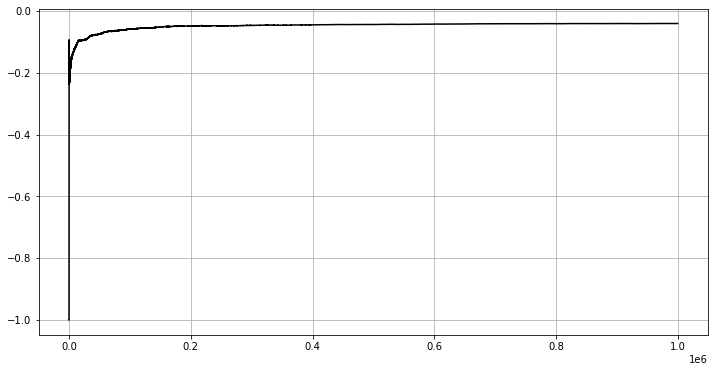

In [19]:
info_pi(pi, average_reward)

In [20]:
plot_strategy(pi) 

,p: 4,p: 5,p: 6,p: 7,p: 8,p: 9,p: 10,p: 11,p: 12,p: 13,p: 14,p: 15,p: 16,p: 17,p: 18,p: 19,p: 20,p: 21
"d: 1, u_a: True",stand,stand,hit,hit,stand,stand,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand
"d: 1, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand
"d: 2, u_a: True",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand
"d: 2, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand,stand,stand,stand,stand,stand
"d: 3, u_a: True",stand,hit,hit,hit,hit,stand,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand
"d: 3, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand,stand,stand,stand,stand,stand
"d: 4, u_a: True",hit,stand,hit,hit,stand,hit,hit,stand,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand
"d: 4, u_a: False",stand,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand,stand,stand,stand,stand,stand
"d: 5, u_a: True",stand,stand,stand,stand,hit,hit,stand,stand,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand
"d: 5, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,stand,stand,stand,stand,stand,stand,hit


Средний выйгрыш по найденной стратегии для базового варианта блекджека: -0.029975

### Часть вторая, удвоенная

- Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [21]:
nS, nA = len(STATE_LIST), 3
print(f"Для второй части: количесвто состояний: {nS}, количество дейсвтий: {nA}")

Для второй части: количесвто состояний: 560, количество дейсвтий: 3


In [22]:
env_p2 = BlackjackDoubleEnv(natural=True, sab=False)
total_episodes = 1_000_000
gamma = 1.

pi, average_reward = conduct_experiments(env_p2, eps=0.5, gamma=1.0, total_episodes=total_episodes)

100%|██████████| 1000000/1000000 [03:47<00:00, 4397.51it/s]


In [23]:
env_p2 = BlackjackDoubleEnv(natural=True, sab=False)

mean_total_reward = conduct_experiments_pi(
    env=env_p2, 
    pi=pi, 
    num_experiments=100_000
)

print(f"Средний выйгрыш по найденной стратегии: {mean_total_reward}")

Средний выйгрыш по найденной стратегии: -0.04789


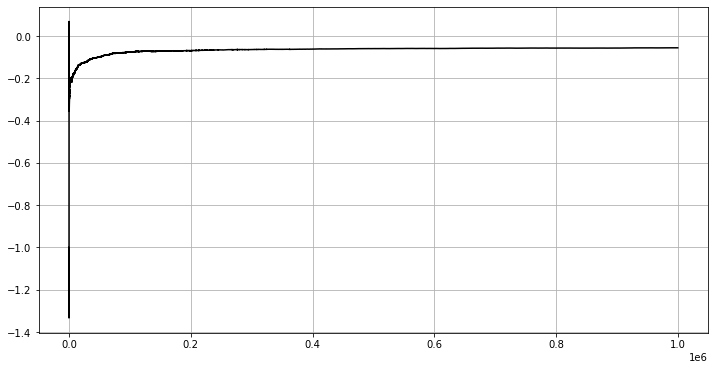

In [24]:
info_pi(pi, average_reward)

In [25]:
plot_strategy(pi) 

,p: 4,p: 5,p: 6,p: 7,p: 8,p: 9,p: 10,p: 11,p: 12,p: 13,p: 14,p: 15,p: 16,p: 17,p: 18,p: 19,p: 20,p: 21
"d: 1, u_a: True",stand,stand,double,hit,double,stand,stand,double,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand
"d: 1, u_a: False",hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,stand,stand,stand,double
"d: 2, u_a: True",double,double,hit,double,stand,hit,hit,double,double,hit,double,hit,hit,hit,stand,stand,stand,stand
"d: 2, u_a: False",hit,hit,hit,hit,hit,double,double,double,stand,stand,stand,stand,stand,stand,stand,stand,stand,stand
"d: 3, u_a: True",double,double,stand,double,double,hit,hit,hit,hit,double,hit,hit,double,double,stand,stand,stand,stand
"d: 3, u_a: False",hit,hit,hit,hit,hit,double,double,double,double,stand,stand,stand,stand,stand,stand,stand,stand,double
"d: 4, u_a: True",double,stand,double,double,hit,double,hit,double,hit,double,double,hit,double,double,stand,stand,stand,stand
"d: 4, u_a: False",hit,hit,hit,hit,hit,double,double,double,stand,stand,stand,stand,stand,stand,stand,stand,stand,double
"d: 5, u_a: True",hit,hit,stand,stand,double,stand,double,stand,double,double,hit,double,double,double,double,stand,stand,stand
"d: 5, u_a: False",hit,hit,hit,hit,double,double,double,double,stand,stand,stand,stand,stand,stand,stand,stand,stand,stand


Средний выйгрыш по найденной стратегии для блекджека с удвоением: -0.04789

### Часть третья, в главной роли — Дастин Хоффман

- Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

##### Система подсчета - "плюс-минус"

In [32]:
COUNTING_SYSTEM = "plus-minus"

if COUNTING_SYSTEM == "plus-minus":
    COUNTING_LIST = list(range(-20, 21))
elif COUNTING_SYSTEM == "halves":
    COUNTING_LIST = list(range(-44, 45))

COUNT_STATE = len(PLAYER_CARD) * len(DEALER_CARD) * len(USABLE_ACE_LIST) * len(COUNTING_LIST)
print(f"Количество возможных состояний: {COUNT_STATE}\n")

idx_to_state, state_to_idx, STATE_LIST = make_dict_states(counting_system=COUNTING_LIST)

nS, nA = len(STATE_LIST), 3
print(f"Для первой части: количесвто состояний: {nS}, количество дейсвтий: {nA}")

Количество возможных состояний: 22960

Для первой части: количесвто состояний: 22960, количество дейсвтий: 3


In [33]:
env_p3 = BlackjackCountCardEnv(counting_system=COUNTING_SYSTEM, natural=True, sab=False)
total_episodes = 1_000_000
gamma = 1.

pi, average_reward = conduct_experiments(env_p3, eps=0.5, gamma=1.0, 
                                         total_episodes=total_episodes, is_counting_game=True)

100%|██████████| 1000000/1000000 [06:46<00:00, 2459.84it/s]


In [34]:
env_p3 = BlackjackCountCardEnv(counting_system=COUNTING_SYSTEM, natural=True, sab=False)

mean_total_reward = conduct_experiments_pi(
    env=env_p3, 
    pi=pi, 
    num_experiments=100_000
)

print(f"Средний выйгрыш по найденной стратегии: {mean_total_reward}")

Средний выйгрыш по найденной стратегии: -0.033275


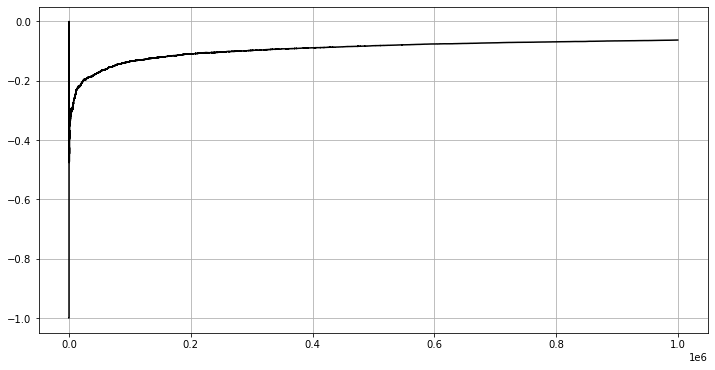

In [35]:
info_pi(pi, average_reward)

Средний выйгрыш по найденной стратегии для блекджека с системой подсчета карт "плюс-минус": -0.033275

##### Система подсчета - "половинки"

In [36]:
COUNTING_SYSTEM = "halves"

if COUNTING_SYSTEM == "plus-minus":
    COUNTING_LIST = list(range(-20, 21))
elif COUNTING_SYSTEM == "halves":
    COUNTING_LIST = list(range(-44, 45))

COUNT_STATE = len(PLAYER_CARD) * len(DEALER_CARD) * len(USABLE_ACE_LIST) * len(COUNTING_LIST)
print(f"Количество возможных состояний: {COUNT_STATE}\n")

idx_to_state, state_to_idx, STATE_LIST = make_dict_states(counting_system=COUNTING_LIST)

nS, nA = len(STATE_LIST), 3
print(f"Для первой части: количесвто состояний: {nS}, количество дейсвтий: {nA}")

Количество возможных состояний: 49840

Для первой части: количесвто состояний: 49840, количество дейсвтий: 3


In [37]:
env_p3 = BlackjackCountCardEnv(counting_system=COUNTING_SYSTEM, natural=True, sab=False)
total_episodes = 1_000_000
gamma = 1.

pi, average_reward = conduct_experiments(env_p3, eps=0.5, gamma=1.0, 
                                         total_episodes=total_episodes, is_counting_game=True)

100%|██████████| 1000000/1000000 [10:56<00:00, 1522.89it/s]


In [38]:
env_p3 = BlackjackCountCardEnv(counting_system=COUNTING_SYSTEM, natural=True, sab=False)

mean_total_reward = conduct_experiments_pi(
    env=env_p3, 
    pi=pi, 
    num_experiments=100_000
)

print(f"Средний выйгрыш по найденной стратегии: {mean_total_reward}")

Средний выйгрыш по найденной стратегии: -0.048815


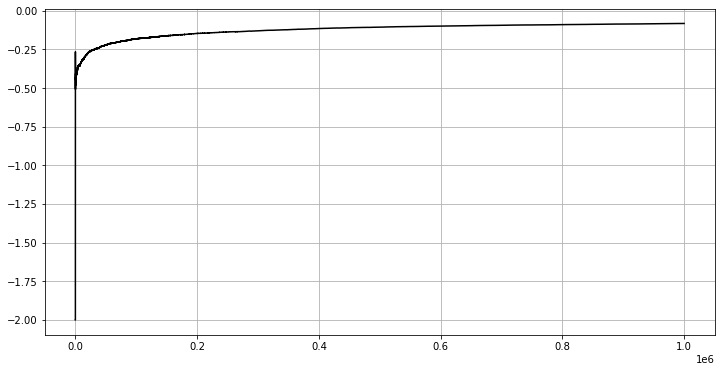

In [39]:
info_pi(pi, average_reward)

Средний выйгрыш по найденной стратегии для блекджека с системой подсчета карт "половинки": -0.048815

##### Все-таки блекджек - игра азартная и желание победить казино взяло свое. Обучив стратегию с системой полдсчета карт "половинки" на 50 миллионах игр удалось добиться среднего выйгрыша 0,001, но это разумеется без доказательств)